# Opposition Analysis: Italy  [Euro 2024]

## Libraries 

In [93]:
import pandas as pd
import json
from IPython.display import display

from mplsoccer import Pitch, VerticalPitch, Sbopen, FontManager

from adjustText import adjust_text

import math
from urllib.request import urlopen

import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns


In [94]:
import pandas as pd
import json
from PIL import Image
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, Pitch

## Group C Results 

In [ ]:
results = pd.DataFrame([('5414320', '1381508' ,'20.11.2023', 'A', 'Ukraine', 0, 0, True), 
                        ('5414299', '1381487' ,'17.11.2023', 'H', 'North Macedonia', 5,2, False), 
                        ('5414280', '1381470' , '17.10.2023', 'A', 'England', 3, 1, True), 
                        ('5414261', '1381449' ,'14.10.2023', 'H', 'Malta', 4,0, False), 
                        ('5414234', '1381426','12.09.2023', 'H', 'Ukraine', 2, 1, False), 
                        ('5414214', '' ,'09.09.2023', 'A', 'North Macedonia', 1, 1, True), 
                        ('5414130', '' ,'26.03.2023', 'A', 'Malta', 0,2, True), 
                        ('5414104', '' ,'23.03.2023', 'H', 'England', 1,2, False)],
                        columns=['wyscoutid','skillcornerid','Date', 'Location', 'Opponent', 'Home Goals', 'Away Goals', 'Away Fixture'])

results = results.sort_values(by='wyscoutid', ascending=True)
results = results.reset_index(drop=True)
print(results)

## Soccerbars chart 

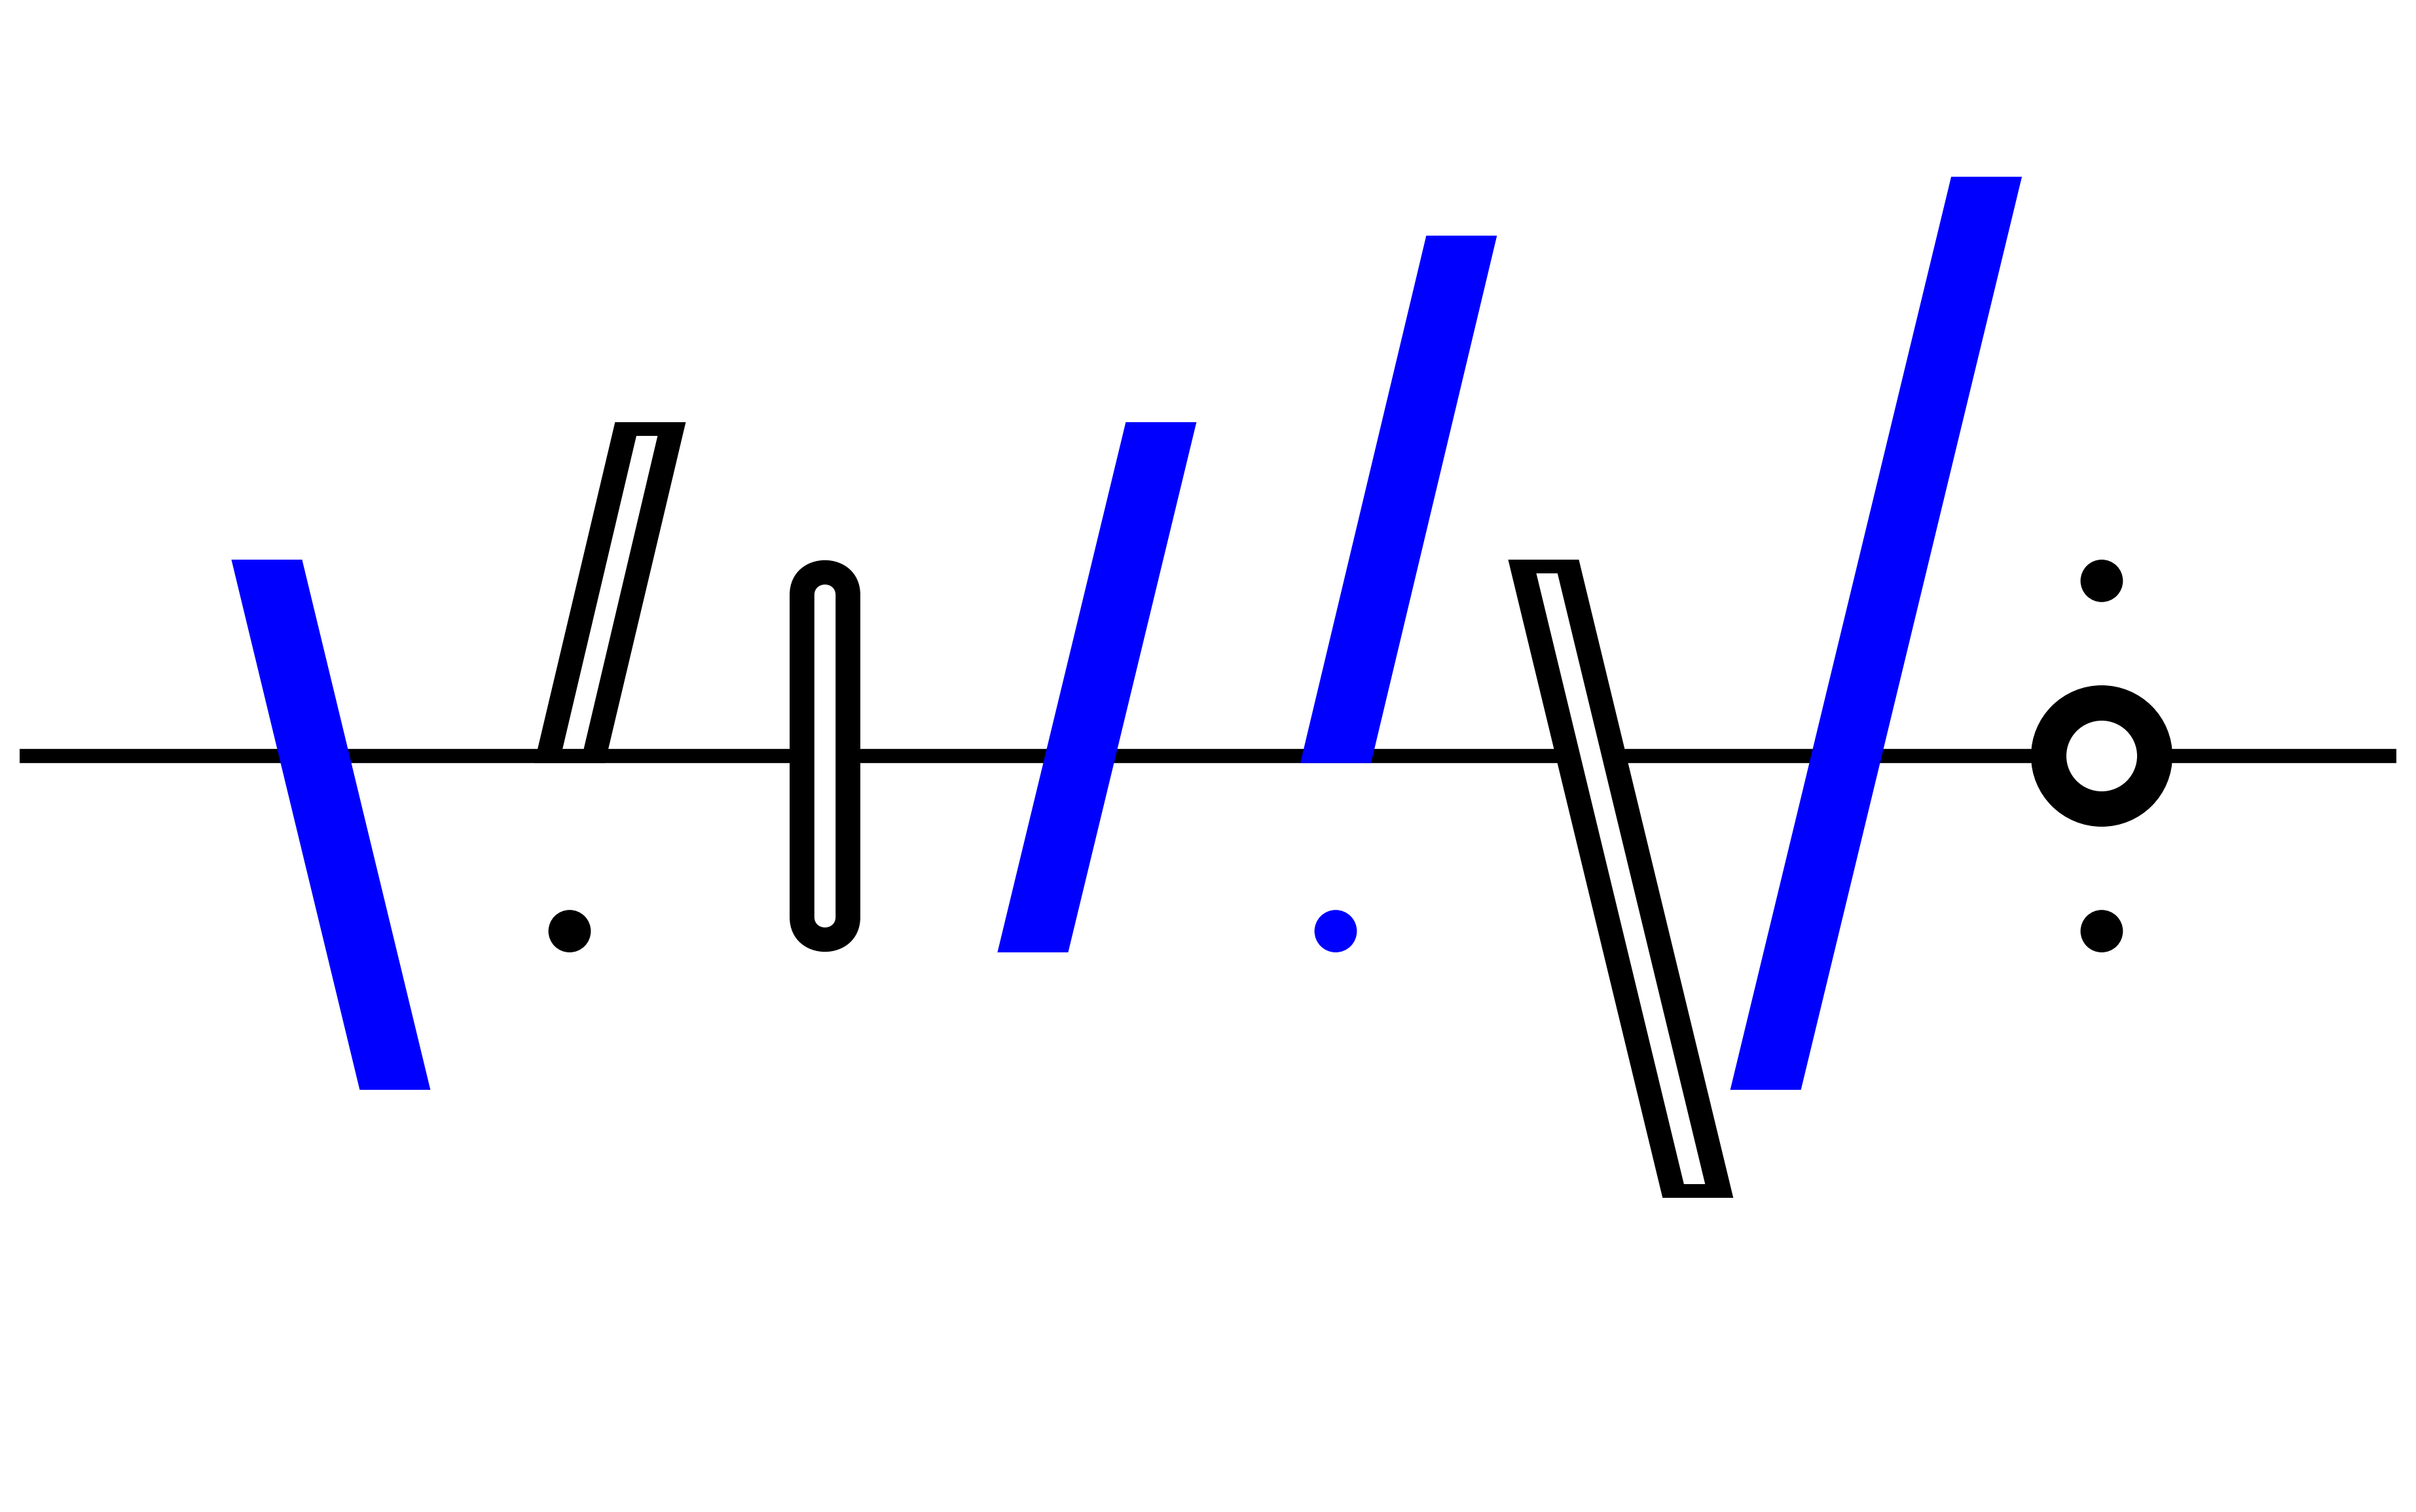

<Axes: >

In [96]:
from soccerbars import soccerbar

matches = results[['Home Goals', 'Away Goals', 'Away Fixture']]
#print(matches)

soccerbar((matches), outlined=True, output_path="matches.png", home_color="blue", zerodots=True, spacing = 1.3)


## Wyscout json files conversion to csv and creation of one csv event file with all matches 

In [97]:
base_path = '/Users/andreasmavrakis/Python/SoccerAnalytics/Primer/input/wyscout'
#file_name = '5414104.json'

In [98]:
def wyscout_json_to_df(file_name):
    with open(base_path+ '/' +file_name, encoding='utf8') as f:
        js = json.load(f)
        df = pd.json_normalize(js['events'])
    return df

Transform wyscout files to csv pandas dataframe

In [131]:
#Creation of csv pandas dataframes of all wyscout files and a dataframe with all of them

all_matches = pd.DataFrame()

# Iterate over the values in the 'filename' column and save each DataFrame to CSV
for filename in results['wyscoutid']:
    # Assuming each filename doesn't contain any characters invalid for filenames
    # You might want to sanitize the filename if necessary
    file_name = f"{filename}.json"
    df_events = wyscout_json_to_df(file_name)
    df_events.to_csv(f"{filename}.csv", index = False)
 
    all_matches = pd.concat([all_matches, df_events], ignore_index=True)

all_matches.to_csv("all_matches.csv", index=False)    


check for all potential tags in the dataframe

In [ ]:
print(all_matches.columns[0:50], "\n")

In [ ]:
print(all_matches.columns[49:150], "\n")

## Formations, Lineups and Substitutions(?) 

[Formal Starting Lineups Pictures vs Actual Position] 
[Substitutions: how can i spot them from events data?]

In [ ]:
# Take the part of the dataframe that has only the actions of Italy
df_Italy = all_matches[(all_matches['team.name']=='Italy')]

# use wyscoutid from the simple initial table(results) with every match
results['wyscoutid'] = results['wyscoutid'].astype(int)

# take game id's
game_id = results['wyscoutid']
#print(game_id)

# drop some columns not needed form the initial results table
results_short = results.drop(columns = ['skillcornerid','Away Fixture'])

#create empty arrays that will be used
unique_starting_formation = []
unique_formations = []

# For each game repeat and extract every formation used. Print the starting formation and all the players played in that  

for gameid in game_id:
    #print row with information of the specific game from the results table 
    print("\n",results_short.loc[results_short["wyscoutid"] == gameid])
    
    # Formations extraction (starting and all)
    formations = df_Italy[df_Italy['matchId'] == gameid]['team.formation'].unique()
    starting_formation = df_Italy[df_Italy['matchId'] == gameid ]['team.formation'].iloc[0]
    
    print("\nStarting Formation:",starting_formation)
    print("\nFormations during game:",formations)
    
    # add them to the initial general tables with all starting and formations
    unique_starting_formation.append(starting_formation)
    unique_formations.extend(formations)
        
    # Lineups extraction for each formation on the game 
    
    for formation in formations:
        
        print("\nLineup in Formation:",formation,"\n")
        filtered_df = df_Italy[(df_Italy['matchId'] == gameid) & (df_Italy['team.formation'] == formation)]
        #unique_player_names = df_Italy['player.name'].unique()
        #print(unique_player_names)
        lineups = filtered_df [[ 'matchId', 'team.formation','player.id', 'player.name', 'player.position']]
        unique_players_table = lineups.drop_duplicates(subset='player.name')
        unique_players_table = unique_players_table[unique_players_table['player.name'].notna()]
        print(unique_players_table)
        


In [103]:
# Print overall all the starting formations of Italy and all formations used in general

unique_starting_formation = list(set(unique_starting_formation))
unique_formations = list(set(unique_formations))
print("\nItaly starting formations:", unique_starting_formation)
print("\nItaly formations:", unique_formations)


Italy starting formations: ['4-3-3', '4-1-4-1', '5-3-2']

Italy formations: ['4-3-3', '5-3-2', '4-4-2', '4-5-1', '4-1-4-1']


## Descriptive Statistics

### Average Possession (?)

In [ ]:
df_Italy[['possession.id', 'possession.duration','possession.types', 'possession.eventsNumber', 'possession.eventIndex',
       'possession.startLocation.x', 'possession.startLocation.y',
       'possession.endLocation.x', 'possession.endLocation.y',
       'possession.team.id', 'possession.team.name',
       'possession.team.formation', 'possession.attack', 'pass',
       'carry.progression']]

### Goals Scored Stats [Done]

#### Average goals per match, Average shots per match, Goals per shots [Scored]

Report for each specific game

In [ ]:
all_shots = []
all_goals = []
all_goals_per_shot = []

# For each game 

for gameid in game_id:
    print("\n",results_short.loc[results_short["wyscoutid"] == gameid],"\n")
    
    # keep only the rows for the specific gameid
    df_game = df_Italy[df_Italy['matchId'] == gameid]
    # shots without penalties or free kicks
    df_shots = df_game[(df_game['type.primary']=='shot')]
    # penalties
    df_pens = df_game[(df_game['type.primary']=='penalty')]
    # Free kick shots
    df_fk = df_game[(df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    # shots and penalties
    df_shots_pens = df_game[(df_game['type.primary']=='shot') | (df_game['type.primary']=='penalty')]
    # shots and penalties and free kicks 
    df_shots_pens_fk = df_game[(df_game['type.primary']=='shot') | (df_game['type.primary']=='penalty') | (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    # goals from penalty
    df_goal_pens = df_game[(df_game['shot.isGoal']==True) & (df_game['type.primary']=='penalty')]
    # goals from free kicks
    df_goal_fk = df_game[(df_game['shot.isGoal']==True) & (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    # goals
    df_goals = df_shots_pens_fk[df_shots_pens_fk['shot.isGoal']==True]
    
    # calculation of overall attributes, by adding theam for each game
    shots = len(df_shots_pens_fk)
    goals = len(df_goals)
    goals_per_shot = len(df_goals)/len(df_shots)
    pens = len(df_pens)
    goal_pens = len(df_goal_pens)
    fks = len(df_fk)
    goal_fk = len(df_goal_fk)
    
    all_shots.append(shots)
    all_goals.append(goals)
    all_goals_per_shot.append(goals_per_shot)
    
    
    print("Total shots:", shots)
    print("Total penalties:", pens)
    print("Total free kick shots attempts:", fks)
    print("Number of goals from free kicks:",goal_fk)
    print("Number of goals from penalties:",goal_pens)
    print("Number of goals:", goals)
    print("Goals per shot: {:.2f}".format(goals/shots),"\n")
    
    print("Scorers:")
    display(df_goals[['matchTimestamp', 'team.name','player.id', 'player.name', 'type.primary', 'type.secondary']])
    df_shots['shot.onTarget']


In [106]:
print(all_goals)

[1, 2, 1, 2, 4, 1, 5, 0]


In [107]:
print("Achieved in Attack:\n")
print("Number of shots in qualifiers:", sum(all_shots))
print("Number of goals in qualifiers:", sum(all_goals))
print("Average shots per game: {:.2f}".format(sum(all_shots)/len(all_shots)))
print("Average goals per game: ", sum(all_goals)/len(all_goals))
print("Average goals per shots: {:.2f}".format(sum(all_goals_per_shot)/len(all_goals_per_shot)))


Achieved in Attack:

Number of shots in qualifiers: 116
Number of goals in qualifiers: 16
Average shots per game: 14.50
Average goals per game:  2.0
Average goals per shots: 0.14


#### Scorers Ranking

In [ ]:
df_all_shots = df_Italy[(df_Italy['type.primary']=='shot') | (df_Italy['type.primary']=='penalty') | (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
#print(df_all_shots)
df_gls = df_all_shots[df_all_shots['shot.isGoal']==True] 
df_scorers = df_gls[['id','matchId','matchTimestamp','player.id', 'player.name', 'player.position','type.primary', 'type.secondary']]

print("All goals in qualifiers:\n")
display(df_scorers)

scorers_rank = df_scorers.groupby(['player.id', 'player.name']).size().reset_index(name='goals')
print(scorers_rank)
# Merge with df_scorers to get corresponding player positions
scorers_rank = scorers_rank.merge(df_scorers[['player.id', 'player.position']], on='player.id', how='left')
# Drop duplicates to ensure unique player.id and player.name combinations
scorers_rank = scorers_rank.drop_duplicates(['player.id', 'player.name'])
# Reorder the columns
scorers_rank = scorers_rank[['player.id', 'player.name', 'player.position', 'goals']]


# Sort by counts in descending order
scorers_rank_sorted = scorers_rank.sort_values(by='goals', ascending=False)
scorers_rank_sorted = scorers_rank_sorted.reset_index(drop=True)
scorers_rank_sorted.index += 1

print("Scorers of Italy in Euro Qualifiers: \n")
display(scorers_rank_sorted)


#### Goals Time Distribution [0-15, 15-30, 30-45,45-60, 60-75, 75-90]

In [109]:
df_scorers = df_gls[['id','matchId','matchTimestamp','matchPeriod','player.id', 'player.name', 'player.position','type.primary', 'type.secondary']]
df_scorers = df_scorers.reset_index(drop=True)
display(df_scorers)


,id,matchId,matchTimestamp,matchPeriod,player.id,player.name,player.position,type.primary,type.secondary
0,1587031793,5414104,00:55:52.016,2H,551694,M. Retegui,CF,shot,"[goal, opportunity, touch_in_box]"
1,1615281127,5414130,00:14:37.824,1H,551694,M. Retegui,CF,shot,"[goal, head_shot, opportunity, shot_after_corn..."
2,1615281315,5414130,00:26:28.294,1H,272893,M. Pessina,RCMF3,shot,"[goal, opportunity, touch_in_box]"
3,1752238520,5414214,00:46:11.757,2H,21384,C. Immobile,CF,shot,"[goal, head_shot, opportunity, touch_in_box]"
4,1750696098,5414234,00:11:48.636,1H,423151,D. Frattesi,RCMF3,shot,"[goal, opportunity, touch_in_box]"
5,1750696451,5414234,00:28:11.654,1H,423151,D. Frattesi,RCMF3,shot,"[goal, opportunity, touch_in_box]"
6,1804453379,5414261,00:22:03.137,1H,20845,G. Bonaventura,LCMF3,shot,"[goal, opportunity, touch_in_box]"
7,1804453880,5414261,00:45:14.922,1H,209400,D. Berardi,RWF,shot,"[goal, opportunity, touch_in_box]"
8,1804454351,5414261,01:03:01.385,2H,209400,D. Berardi,RW,shot,"[goal, opportunity, touch_in_box]"
9,1804454939,5414261,01:32:52.678,2H,423151,D. Frattesi,RCMF,shot,"[goal, opportunity, shot_after_throw_in]"


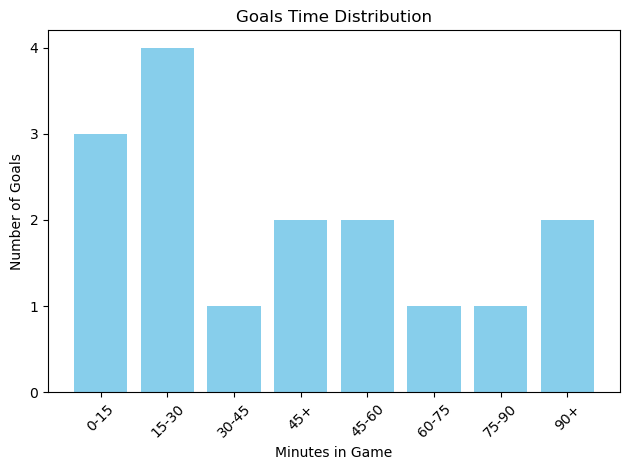

In [110]:
df_scorers_copy = df_scorers.copy()

# Convert 'matchTimestamp' column to Timedelta
df_scorers_copy['matchTimedelta'] = pd.to_timedelta(df_scorers_copy['matchTimestamp'])

# Convert Timedelta column to minutes
df_scorers_copy['time_minutes'] = df_scorers_copy['matchTimedelta'].dt.total_seconds() / 60

# Initialize variables
interval_counts = {
    '0-15': 0,
    '15-30': 0,
    '30-45': 0,
    '45+': 0,
    '45-60': 0,
    '60-75': 0,
    '75-90': 0,
    '90+': 0
}

# Iterate through DataFrame rows
for index, row in df_scorers_copy.iterrows():
    # Extract matchTimestamp minutes value
    match_minutes = row['time_minutes']

    # Extract matchPeriod value
    match_period = row['matchPeriod']

    # Increment variables based on conditions
    if 0 <= match_minutes < 15:
        interval_counts['0-15'] += 1
    elif 15 <= match_minutes < 30:
        interval_counts['15-30'] += 1
    elif 30 <= match_minutes < 45:
        interval_counts['30-45'] += 1
    elif match_minutes > 45 and match_period == '1H':
        interval_counts['45+'] += 1
    elif 45 <= match_minutes < 60:
        interval_counts['45-60'] += 1
    elif 60 <= match_minutes < 75:
        interval_counts['60-75'] += 1
    elif 75 <= match_minutes < 90:
        interval_counts['75-90'] += 1
    elif match_minutes > 90 and match_period == '2H':
        interval_counts['90+'] += 1

# Create lists for x and y values
intervals = list(interval_counts.keys())
counts = list(interval_counts.values())

# Plot the bar chart
plt.bar(intervals, counts, color='skyblue')

# Add labels and title
plt.xlabel('Minutes in Game')
plt.ylabel('Number of Goals')
plt.title('Goals Time Distribution')

# Set y-axis ticks without 0.5 decimals
plt.yticks(range(0, max(counts) + 1))

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Goal Type Distribution [Cross, Attack Centre (direct free kick & penalty), Counter Attack, Long Shots, Individual skill]

In [111]:
## display(df_scorers['type.secondary'])

# Extract all potential objects from the lists
potential_objects = set()
for lst in df_scorers['type.secondary']:
    for obj in lst:
        potential_objects.add(obj)
        
print(potential_objects)

# Create arrays/groups with potential object names
object_counts = {obj: 0 for obj in potential_objects}

# Count occurrences of each potential object
for lst in df_scorers['type.secondary']:
    for obj in lst:
        object_counts[obj] += 1
        
# Print the counts
print("Counts of potential objects:")
print(object_counts)

{'shot_after_corner', 'touch_in_box', 'head_shot', 'shot_after_throw_in', 'goal', 'opportunity'}
Counts of potential objects:
{'shot_after_corner': 2, 'touch_in_box': 14, 'head_shot': 3, 'shot_after_throw_in': 2, 'goal': 16, 'opportunity': 16}


Counts for each group:
{'In the box': 14, 'Outside the box': 2, 'Header': 3, 'Shot': 13, 'Corner': 2, 'Throw-in': 2, 'Throw-in/Outside the box/Shot': 2, 'Corner/In the box/Header': 2, 'Free Kick': 0, 'Penalty': 0}


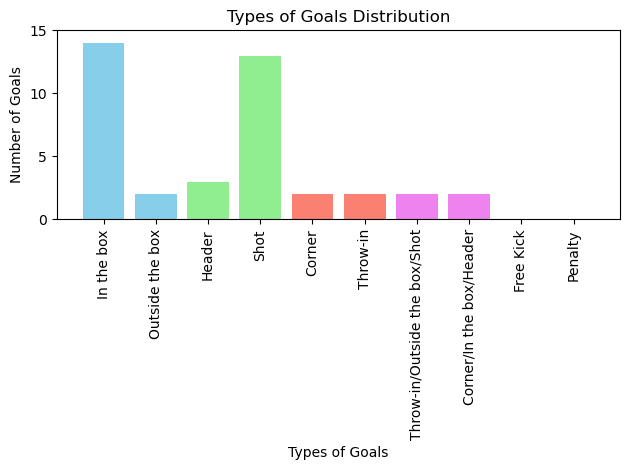

In [112]:
# Define the groups
groups = {
    'In the box': ['touch_in_box'],
    'Outside the box': ['!touch_in_box'], 
    'Header': ['head_shot'],
    #'Header in the box':['touch_in_box','head_shot'],
    'Shot': ['!head_shot'],
    'Corner': ['shot_after_corner'],
    'Throw-in': ['shot_after_throw_in'],
    'Throw-in/Outside the box/Shot': ['shot_after_throw_in', '!touch_in_box'],
    'Corner/In the box/Header': ['touch_in_box','head_shot','shot_after_corner',],
    'Free Kick': ['free_kick_shot'],
    'Penalty': ['penalty_goal']
}

# Initialize counts for each group
group_counts = {group: 0 for group in groups}

# Count occurrences of each group
for _, row in df_scorers.iterrows():
    for group, group_objects in groups.items():
        if all(obj in row['type.secondary'] for obj in group_objects if '!' not in obj):
            if all(obj not in row['type.secondary'] for obj in (obj[1:] for obj in group_objects if '!' in obj)):
                group_counts[group] += 1

# Print the counts for each group
print("Counts for each group:")
print(group_counts) 

#Plotting

# Convert the group_counts dictionary to lists for plotting
group_names = list(group_counts.keys())
counts = list(group_counts.values())

# Define colors for pairwise grouping
colors = ['skyblue', 'lightgreen', 'salmon', 'violet']

# Plot the bar chart with pairwise colors
for i in range(len(group_names)):
    color_index = (i // 2) % len(colors)  # Alternate between four colors
    plt.bar(group_names[i], counts[i], color=colors[color_index])

# Add labels and title
plt.xlabel('Types of Goals')
plt.ylabel('Number of Goals')
plt.title('Types of Goals Distribution')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Specify the positions of the ticks on the y-axis
plt.locator_params(axis='y', integer=True)
plt.ylim(0, int(max(counts)) + 1)

# Show the plot
plt.tight_layout()
plt.show()

#### Plotting Shots


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
0    5414104  23.03.2023        H  England           1           2 

        Shots  Count
0  Off Target      6
1   On Target      1


/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


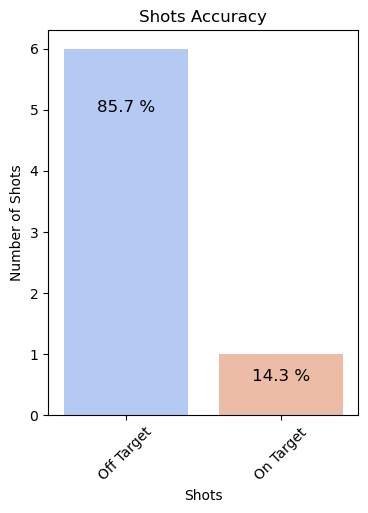

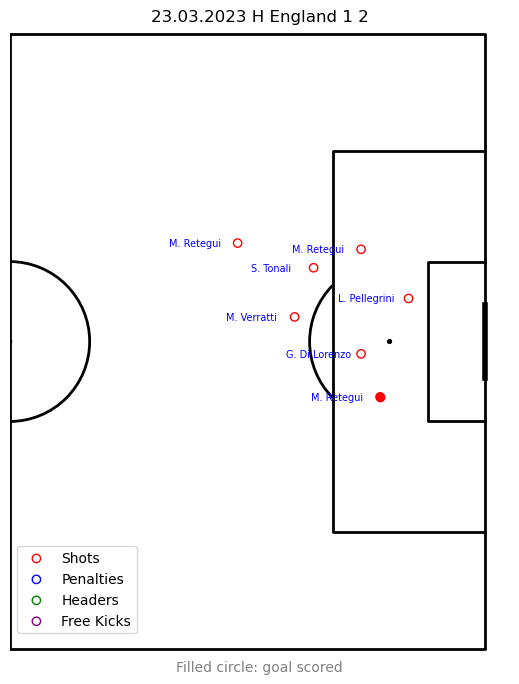


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
1    5414130  26.03.2023        A    Malta           0           2 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


        Shots  Count
0  Off Target     10
1   On Target      6


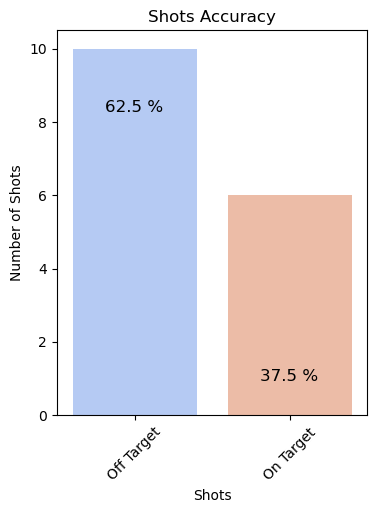

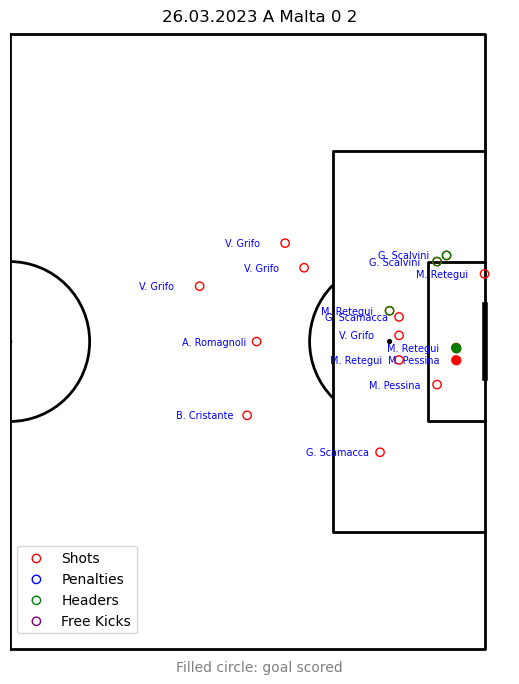


    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
2    5414214  09.09.2023        A  North Macedonia           1           1 

        Shots  Count
0  Off Target      8
1   On Target      3


/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


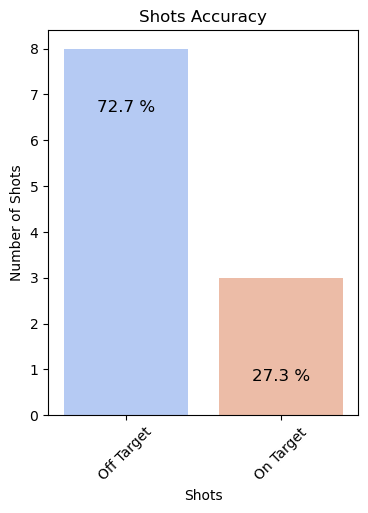

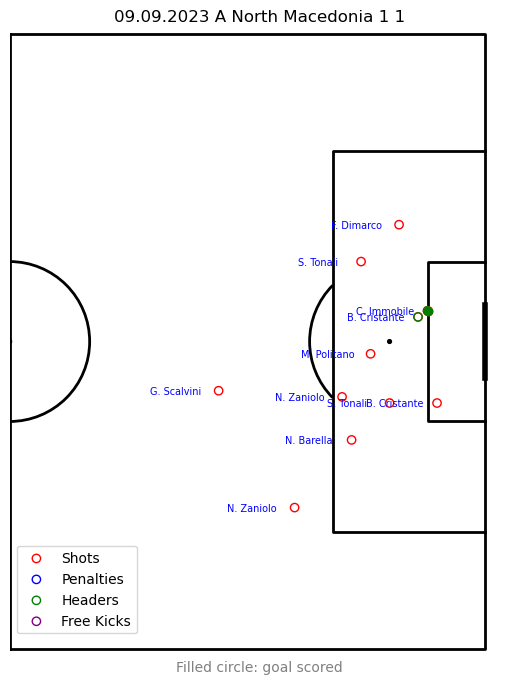


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
3    5414234  12.09.2023        H  Ukraine           2           1 

        Shots  Count
0  Off Target     16
1   On Target      5


/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


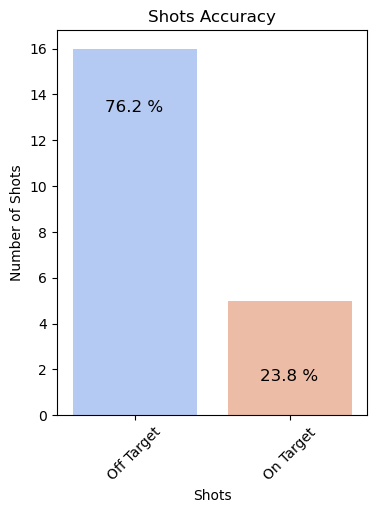

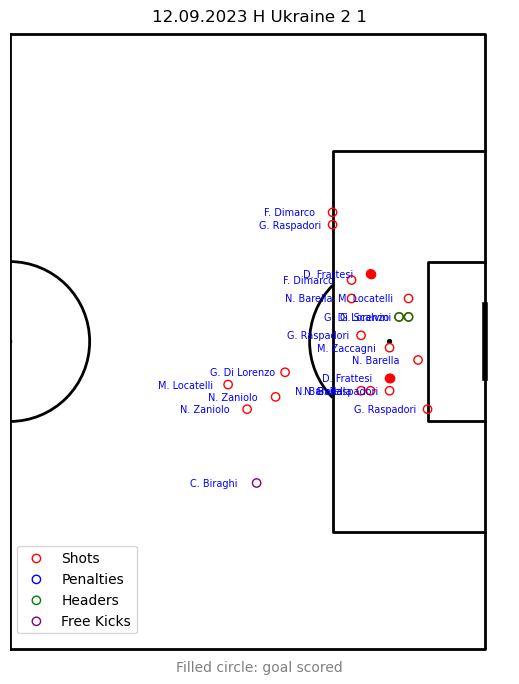


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
4    5414261  14.10.2023        H    Malta           4           0 

        Shots  Count
0  Off Target     11
1   On Target      4


/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


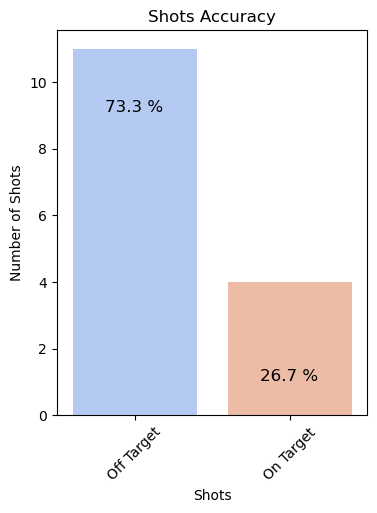

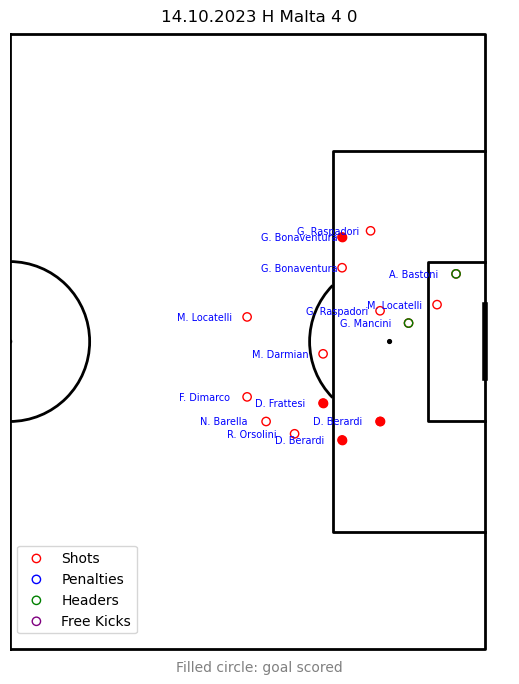


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
5    5414280  17.10.2023        A  England           3           1 

        Shots  Count
0  Off Target      9
1   On Target      4


/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


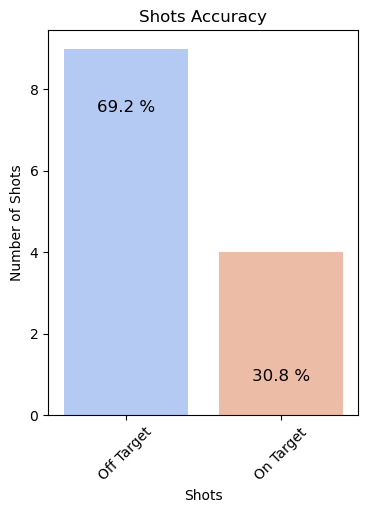

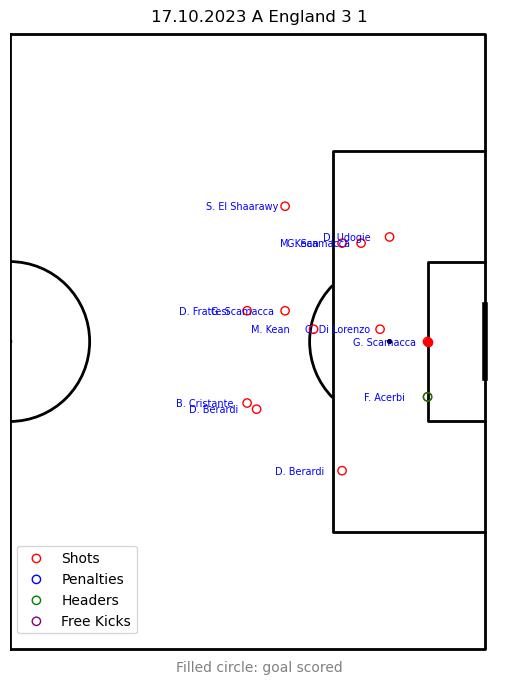


    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
6    5414299  17.11.2023        H  North Macedonia           5           2 

        Shots  Count
0  Off Target     11
1   On Target      7


/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


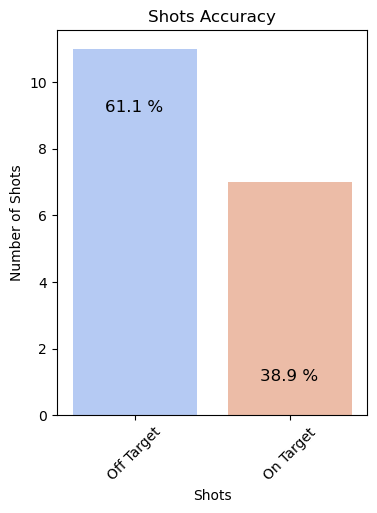

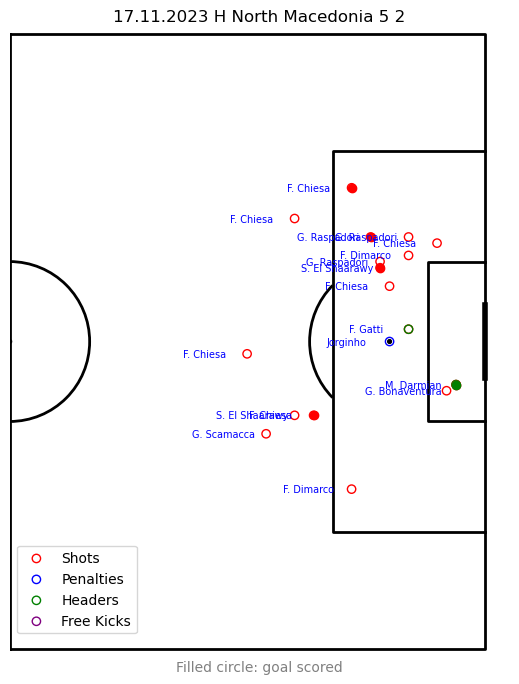


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
7    5414320  20.11.2023        A  Ukraine           0           0 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/4092058723.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Off Target', 'On Target']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']


        Shots  Count
0  Off Target     13
1   On Target      2


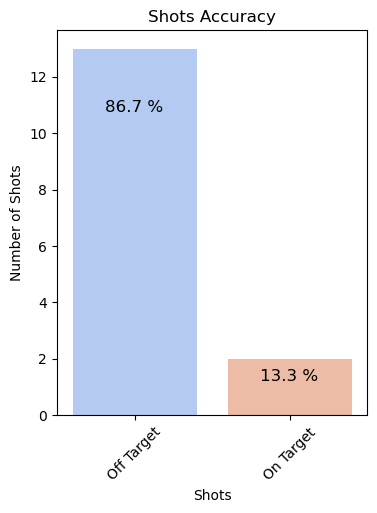

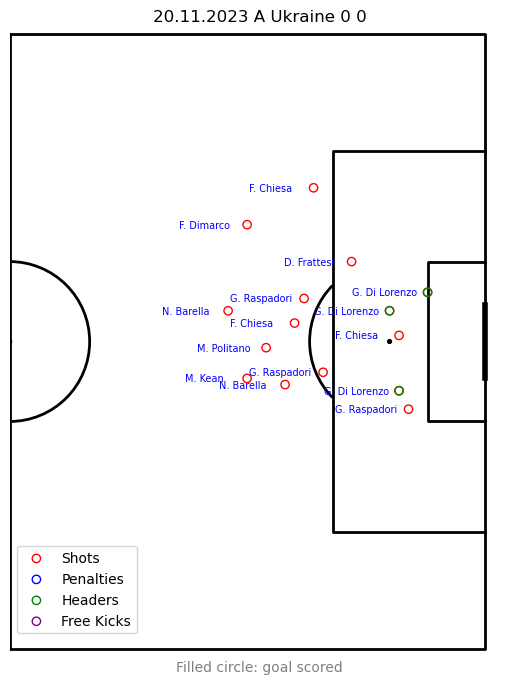

In [113]:
for gameid in game_id:
    game_info = results_short.loc[results_short["wyscoutid"] == gameid]
    print("\n", game_info, "\n")
    
    # Keep only the rows for the specific gameid
    df_game = df_Italy[df_Italy['matchId'] == gameid]
    
    # Pure shots and goals from shots
    df_shots = df_game[(df_game['type.primary'] == 'shot') & (~df_game['type.secondary'].isin(['head_shot']))]
    df_goal_shots = df_shots[df_shots['shot.isGoal'] == True]
    
    # Penalties and goals from penalties
    df_pens = df_game[df_game['type.primary'] == 'penalty']
    # print(df_pens)
    df_goal_pens = df_pens[df_pens['shot.isGoal'] == True]
    
    # Shots-header and goals from header
    df_header = df_game[(df_game['type.primary'] == 'shot') & (df_game['type.secondary'].apply(lambda x: 'head_shot' in x))]
    df_goal_header = df_header[df_header['shot.isGoal'] == True]
    
    # Free Kicks
    df_freekick = df_game[(df_game['type.primary'] == 'free_kick') & (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    df_goal_freekick = df_freekick[df_freekick['shot.isGoal'] == True]
    
    
    ### Plot on target/off target
    
    # All Shots, including penalties
    df_all_shots = df_game[(df_game['type.primary'] == 'shot') | (df_game['type.primary'] == 'penalty') | (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    df_all_goals = df_goals = df_all_shots[df_all_shots['shot.isGoal']==True]
    
    #we count the on target (true) and off target shots (false)
    on_target_count = df_all_shots['shot.onTarget'].value_counts().reset_index()

    # Rename the columns for better readability
    on_target_count.columns = ['Shots', 'Count']
    on_target_count.loc[:1, 'Shots'] = ['Off Target', 'On Target']
    total_shots = sum(on_target_count['Count'])
    off_target_percentage = on_target_count['Count'].iloc[0]/total_shots
    on_target_percentage = on_target_count['Count'].iloc[1]/total_shots
    
    print(on_target_count)

    # Apply a Seaborn theme
    #sns.set_theme(style="darkgrid")
    # setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(4, 5))
    # Choose a color palette for the plot
    palette = sns.color_palette("coolwarm", len(on_target_count))

    # Create the bar chart with the chosen palette
    sns.barplot(x='Shots', y='Count', data=on_target_count, palette=palette)
    # Remove x-axis tick labels
    #plt.figure(figsize=(8, 6)) 
    #Set the title of the plot
    plt.title('Shots Accuracy')

    # Customize further with Seaborn and Matplotlib
    plt.xlabel('Shots') # X-axis label
    plt.ylabel('Number of Shots')    # Y-axis label

    # Optional: Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    note = f"{100*off_target_percentage:.1f} %"
    plt.annotate(note, xy=(0.3, 0.5), xytext=(0.25, 0.8), xycoords='axes fraction', fontsize=12, ha='center', va='center')
    
    note = f"{100*on_target_percentage:.1f} %"
    plt.annotate(note, xy=(0.3, 0.5), xytext=(0.75, 0.1), xycoords='axes fraction', fontsize=12, ha='center', va='center')

    # Show the plot
    #plt.show()
    
    ## Shot map plotting
    
    # Define the pitch dimensions
    pitch_length = 105  # in meters

    # Create a pitch
    pitch = Pitch(half=True, pitch_length=pitch_length, line_color='black', pitch_type='wyscout', pad_left=-0.05)
    #pitch = VerticalPitch(half=True, pitch_type='wyscout', goal_type='box', line_color='black', linewidth=3, pad_bottom=-0.1)
    fig, ax = pitch.draw(figsize=(9, 7))
    
    # Plot shots in the right half
    pitch.scatter(df_shots[df_shots['location.x'] > pitch_length / 2]['location.x'], df_shots[df_shots['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='red', label='Shots')

    # Plot penalties in the right half
    pitch.scatter(df_pens[df_pens['location.x'] > pitch_length / 2]['location.x'], df_pens[df_pens['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='blue', label='Penalties')

    # Plot shots from headers in the right half
    pitch.scatter(df_header[df_header['location.x'] > pitch_length / 2]['location.x'], df_header[df_header['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='green', label='Headers')

    # Plot free kick in the right half
    pitch.scatter(df_freekick[df_freekick['location.x'] > pitch_length / 2]['location.x'], df_freekick[df_freekick['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='purple', label='Free Kicks')

    # Plot goals from shots in the right half with fillings
    pitch.scatter(df_goal_shots[df_goal_shots['location.x'] > pitch_length / 2]['location.x'], df_goal_shots[df_goal_shots['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='red')

    # Plot goals from penalties in the right half with fillings
    pitch.scatter(df_goal_pens[df_goal_pens['location.x'] > pitch_length / 2]['location.x'], df_goal_pens[df_goal_pens['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='blue')

    # Plot goals from headers in the right half with fillings
    pitch.scatter(df_goal_header[df_goal_header['location.x'] > pitch_length / 2]['location.x'], df_goal_header[df_goal_header['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='green')
    
    # Plot goals from freekick in the right half with fillings
    pitch.scatter(df_goal_freekick[df_goal_freekick['location.x'] > pitch_length / 2]['location.x'], df_goal_freekick[df_goal_freekick['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='purple')

    game_info = results_short.loc[results_short["wyscoutid"] == gameid].drop(columns=['wyscoutid']).reset_index(drop=True)
    game_info = game_info.to_string(index=False, header=None)
    
    # Add player names and connect them with lines to the shot circles
   
    for index, row in df_shots.iterrows():
        player_name = row['player.name']
        x = row['location.x']  # or  x = row['location.y'] for vertical pitch 
        y = row['location.y']  # or  y = row['location.x'] for vertical pitch
        ax.text(x-4.5, y , player_name, ha='center', va='center', fontsize=7, color='blue')
        
    # Add player names for penalties
    
    for index, row in df_pens.iterrows():
        player_name = row['player.name']
        x = row['location.x']
        y = row['location.y']
        ax.text(x-4.5 , y, player_name, ha='center', va='center', fontsize=7, color='blue')  
        
    # Add player names for free kicks
    
    for index, row in df_freekick.iterrows():
        player_name = row['player.name']
        x = row['location.x']
        y = row['location.y']
        ax.text(x-4.5 , y, player_name, ha='center', va='center', fontsize=7, color='blue') 

    # Show the plot
    plt.legend(bbox_to_anchor=(0, 0.05), loc='lower left')
    plt.title(f'{game_info}', y = 0.97)
    plt.text(0.5, 0.01, 'Filled circle: goal scored', ha='center', va='center', fontsize=10, color='gray', transform=ax.transAxes)

    plt.show() 


### Goals Conceded Stats

Create dataset with only the opponents actions

In [114]:
df_not_Italy = all_matches[(all_matches['team.name']!='Italy')]
#print(df_not_Italy)

##Repetition of the same process that happened in Scored section
# use wyscoutid from the simple initial table(results) with every match
results['wyscoutid'] = results['wyscoutid'].astype(int)

# take game id's
game_id = results['wyscoutid']
#print(game_id)

# drop some columns not needed form the initial results table
results_short = results.drop(columns = ['skillcornerid','Away Fixture'])

#### Average goals per match, Average shots per match, Goals per shots [Conceded]

In [115]:
all_shots = []
all_goals = []
all_goals_per_shot = []

# For each game 

for gameid in game_id:
    print("\n",results_short.loc[results_short["wyscoutid"] == gameid],"\n")
    
    # keep only the rows for the specific gameid
    df_game = df_not_Italy[df_not_Italy['matchId'] == gameid]    
    # shots without penalties or free kicks
    df_shots = df_game[(df_game['type.primary']=='shot')]
    # penalties
    df_pens = df_game[(df_game['type.primary']=='penalty')]
    # Free kick shots
    df_fk = df_game[(df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    # shots and penalties
    df_shots_pens = df_game[(df_game['type.primary']=='shot') | (df_game['type.primary']=='penalty')]
    # shots and penalties and free kicks 
    df_shots_pens_fk = df_game[(df_game['type.primary']=='shot') | (df_game['type.primary']=='penalty') | (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    # goals from penalty
    df_goal_pens = df_game[(df_game['shot.isGoal']==True) & (df_game['type.primary']=='penalty')]
    # goals from free kicks
    df_goal_fk = df_game[(df_game['shot.isGoal']==True) & (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    # goals
    df_goals = df_shots_pens_fk[df_shots_pens_fk['shot.isGoal']==True]
    
    # calculation of overall attributes, by adding theam for each game
    shots = len(df_shots_pens_fk)
    goals = len(df_goals)
    goals_per_shot = len(df_goals)/len(df_shots_pens_fk)
    pens = len(df_pens)
    goal_pens = len(df_goal_pens)
    fks = len(df_fk)
    goal_fk = len(df_goal_fk)
    
    all_shots.append(shots)
    all_goals.append(goals)
    all_goals_per_shot.append(goals_per_shot)
    
    print("Total shots:", shots)
    print("Total penalties:", pens)
    print("Total free kick shots attempts:", fks)
    print("Number of goals from free kicks:",goal_fk)
    print("Number of goals from penalties:",goal_pens)
    print("Number of goals:", goals)
    print("Goals per shot: {:.2f}".format(goals/shots),"\n")
    
    print("Scorers:")
    display(df_goals[['matchTimestamp', 'team.name','player.id', 'player.name', 'type.primary', 'type.secondary']])
    df_shots['shot.onTarget']



    wyscoutid        Date Location Opponent  Home Goals  Away Goals
0    5414104  23.03.2023        H  England           1           2 

Total shots: 7
Total penalties: 1
Total free kick shots attempts: 0
Number of goals from free kicks: 0
Number of goals from penalties: 1
Number of goals: 2
Goals per shot: 0.29 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary
237,00:12:34.247,England,379209,D. Rice,shot,"[goal, opportunity, shot_after_corner, touch_i..."
771,00:43:50.905,England,8717,H. Kane,penalty,"[goal, penalty_goal, shot]"



    wyscoutid        Date Location Opponent  Home Goals  Away Goals
1    5414130  26.03.2023        A    Malta           0           2 

Total shots: 6
Total penalties: 0
Total free kick shots attempts: 0
Number of goals from free kicks: 0
Number of goals from penalties: 0
Number of goals: 0
Goals per shot: 0.00 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary



    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
2    5414214  09.09.2023        A  North Macedonia           1           1 

Total shots: 9
Total penalties: 0
Total free kick shots attempts: 2
Number of goals from free kicks: 1
Number of goals from penalties: 0
Number of goals: 1
Goals per shot: 0.11 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary
4787,01:20:34.420,North Macedonia,280383,E. Bardhi,free_kick,"[free_kick_shot, goal, opportunity, shot]"



    wyscoutid        Date Location Opponent  Home Goals  Away Goals
3    5414234  12.09.2023        H  Ukraine           2           1 

Total shots: 8
Total penalties: 0
Total free kick shots attempts: 1
Number of goals from free kicks: 0
Number of goals from penalties: 0
Number of goals: 1
Goals per shot: 0.12 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary
5881,00:40:36.514,Ukraine,105622,A. Yarmolenko,shot,"[goal, opportunity, touch_in_box]"



    wyscoutid        Date Location Opponent  Home Goals  Away Goals
4    5414261  14.10.2023        H    Malta           4           0 

Total shots: 2
Total penalties: 0
Total free kick shots attempts: 0
Number of goals from free kicks: 0
Number of goals from penalties: 0
Number of goals: 0
Goals per shot: 0.00 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary



    wyscoutid        Date Location Opponent  Home Goals  Away Goals
5    5414280  17.10.2023        A  England           3           1 

Total shots: 10
Total penalties: 1
Total free kick shots attempts: 1
Number of goals from free kicks: 0
Number of goals from penalties: 1
Number of goals: 3
Goals per shot: 0.30 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary
9113,00:31:02.671,England,8717,H. Kane,penalty,"[goal, penalty_goal, shot]"
9580,00:56:17.570,England,397178,M. Rashford,shot,"[goal, opportunity, touch_in_box]"
9916,01:16:04.765,England,8717,H. Kane,shot,"[goal, opportunity, touch_in_box]"



    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
6    5414299  17.11.2023        H  North Macedonia           5           2 

Total shots: 4
Total penalties: 0
Total free kick shots attempts: 0
Number of goals from free kicks: 0
Number of goals from penalties: 0
Number of goals: 2
Goals per shot: 0.50 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary
11162,00:51:11.118,North Macedonia,405645,J. Atanasov,shot,"[goal, head_shot, opportunity, shot_after_corn..."
11578,01:13:14.357,North Macedonia,405645,J. Atanasov,shot,"[goal, opportunity, shot_after_throw_in]"



    wyscoutid        Date Location Opponent  Home Goals  Away Goals
7    5414320  20.11.2023        A  Ukraine           0           0 

Total shots: 6
Total penalties: 0
Total free kick shots attempts: 0
Number of goals from free kicks: 0
Number of goals from penalties: 0
Number of goals: 0
Goals per shot: 0.00 

Scorers:


,matchTimestamp,team.name,player.id,player.name,type.primary,type.secondary


In [116]:
print("Conceded in Defence:\n")
print("Number of shots in qualifiers:", sum(all_shots))
print("Number of goals in qualifiers:", sum(all_goals))
print("Average shots per game: {:.2f}".format(sum(all_shots)/len(all_shots)))
print("Average goals per game: ", sum(all_goals)/len(all_goals))
print("Average goals per shots: {:.2f}".format(sum(all_goals_per_shot)/len(all_goals_per_shot)))

Conceded in Defence:

Number of shots in qualifiers: 52
Number of goals in qualifiers: 9
Average shots per game: 6.50
Average goals per game:  1.125
Average goals per shots: 0.17


#### Goals Time Distribution (scored vs conceded) [0-15, 15-30, 30-45,45-60, 60-75, 75-90]

In [117]:
df_opp_all_shots = df_not_Italy[(df_not_Italy['type.primary']=='shot') | (df_not_Italy['type.primary']=='penalty') | (df_not_Italy['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
#print(df_opp_all_shots)
df_opp_gls = df_opp_all_shots[df_opp_all_shots['shot.isGoal'] == True] 
df_opp_scorers = df_opp_gls[['id','matchId','matchPeriod','matchTimestamp','player.id', 'team.name','player.name', 'player.position','type.primary', 'type.secondary']]

print("All goals in qualifiers:\n")
display(df_opp_scorers)

opp_scorers_rank = df_opp_scorers.groupby(['player.id','team.name','player.name']).size().reset_index(name='counts')

# Sort by counts in descending order
opp_scorers_rank_sorted = opp_scorers_rank.sort_values(by='counts', ascending=False)
opp_scorers_rank_sorted = opp_scorers_rank_sorted.reset_index(drop=True)
opp_scorers_rank_sorted.index += 1

print("Scorers of Italy in Euro Qualifiers: \n")
display(opp_scorers_rank_sorted)

All goals in qualifiers:



,id,matchId,matchPeriod,matchTimestamp,player.id,team.name,player.name,player.position,type.primary,type.secondary
237,1587031802,5414104,1H,00:12:34.247,379209,England,D. Rice,DMF,shot,"[goal, opportunity, shot_after_corner, touch_i..."
771,1587032555,5414104,1H,00:43:50.905,8717,England,H. Kane,CF,penalty,"[goal, penalty_goal, shot]"
4787,1752238957,5414214,2H,01:20:34.420,280383,North Macedonia,E. Bardhi,AMF,free_kick,"[free_kick_shot, goal, opportunity, shot]"
5881,1750696546,5414234,1H,00:40:36.514,105622,Ukraine,A. Yarmolenko,RAMF,shot,"[goal, opportunity, touch_in_box]"
9113,1802718282,5414280,1H,00:31:02.671,8717,England,H. Kane,CF,penalty,"[goal, penalty_goal, shot]"
9580,1802716707,5414280,2H,00:56:17.570,397178,England,M. Rashford,LW,shot,"[goal, opportunity, touch_in_box]"
9916,1802717158,5414280,2H,01:16:04.765,8717,England,H. Kane,CF,shot,"[goal, opportunity, touch_in_box]"
11162,1845630218,5414299,2H,00:51:11.118,405645,North Macedonia,J. Atanasov,LDMF,shot,"[goal, head_shot, opportunity, shot_after_corn..."
11578,1845630751,5414299,2H,01:13:14.357,405645,North Macedonia,J. Atanasov,RDMF,shot,"[goal, opportunity, shot_after_throw_in]"


Scorers of Italy in Euro Qualifiers: 



,player.id,team.name,player.name,counts
1,8717,England,H. Kane,3
2,405645,North Macedonia,J. Atanasov,2
3,105622,Ukraine,A. Yarmolenko,1
4,280383,North Macedonia,E. Bardhi,1
5,379209,England,D. Rice,1
6,397178,England,M. Rashford,1


In [118]:
df_opp_scorers = df_opp_gls[['id','matchId','matchTimestamp','matchPeriod','player.id', 'team.name', 'player.name', 'player.position','type.primary', 'type.secondary']]
df_opp_scorers = df_opp_scorers.reset_index(drop=True)
display(df_opp_scorers)

,id,matchId,matchTimestamp,matchPeriod,player.id,team.name,player.name,player.position,type.primary,type.secondary
0,1587031802,5414104,00:12:34.247,1H,379209,England,D. Rice,DMF,shot,"[goal, opportunity, shot_after_corner, touch_i..."
1,1587032555,5414104,00:43:50.905,1H,8717,England,H. Kane,CF,penalty,"[goal, penalty_goal, shot]"
2,1752238957,5414214,01:20:34.420,2H,280383,North Macedonia,E. Bardhi,AMF,free_kick,"[free_kick_shot, goal, opportunity, shot]"
3,1750696546,5414234,00:40:36.514,1H,105622,Ukraine,A. Yarmolenko,RAMF,shot,"[goal, opportunity, touch_in_box]"
4,1802718282,5414280,00:31:02.671,1H,8717,England,H. Kane,CF,penalty,"[goal, penalty_goal, shot]"
5,1802716707,5414280,00:56:17.570,2H,397178,England,M. Rashford,LW,shot,"[goal, opportunity, touch_in_box]"
6,1802717158,5414280,01:16:04.765,2H,8717,England,H. Kane,CF,shot,"[goal, opportunity, touch_in_box]"
7,1845630218,5414299,00:51:11.118,2H,405645,North Macedonia,J. Atanasov,LDMF,shot,"[goal, head_shot, opportunity, shot_after_corn..."
8,1845630751,5414299,01:13:14.357,2H,405645,North Macedonia,J. Atanasov,RDMF,shot,"[goal, opportunity, shot_after_throw_in]"


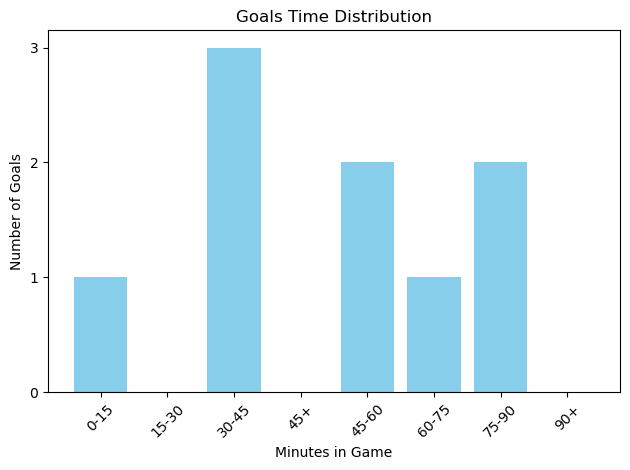

In [119]:
df_opp_scorers_copy = df_opp_scorers.copy()

# Convert 'matchTimestamp' column to Timedelta
df_opp_scorers_copy['matchTimedelta'] = pd.to_timedelta(df_opp_scorers_copy['matchTimestamp'])

# Convert Timedelta column to minutes
df_opp_scorers_copy['time_minutes'] = df_opp_scorers_copy['matchTimedelta'].dt.total_seconds() / 60

# Initialize variables
interval_counts = {
    '0-15': 0,
    '15-30': 0,
    '30-45': 0,
    '45+': 0,
    '45-60': 0,
    '60-75': 0,
    '75-90': 0,
    '90+': 0
}

# Iterate through DataFrame rows
for index, row in df_opp_scorers_copy.iterrows():
    # Extract matchTimestamp minutes value
    match_minutes = row['time_minutes']

    # Extract matchPeriod value
    match_period = row['matchPeriod']

    # Increment variables based on conditions
    if 0 <= match_minutes < 15:
        interval_counts['0-15'] += 1
    elif 15 <= match_minutes < 30:
        interval_counts['15-30'] += 1
    elif 30 <= match_minutes < 45:
        interval_counts['30-45'] += 1
    elif match_minutes > 45 and match_period == '1H':
        interval_counts['45+'] += 1
    elif 45 <= match_minutes < 60:
        interval_counts['45-60'] += 1
    elif 60 <= match_minutes < 75:
        interval_counts['60-75'] += 1
    elif 75 <= match_minutes < 90:
        interval_counts['75-90'] += 1
    elif match_minutes > 90 and match_period == '2H':
        interval_counts['90+'] += 1

# Create lists for x and y values
intervals = list(interval_counts.keys())
counts = list(interval_counts.values())

# Plot the bar chart
plt.bar(intervals, counts, color='skyblue')

# Add labels and title
plt.xlabel('Minutes in Game')
plt.ylabel('Number of Goals')
plt.title('Goals Time Distribution')

# Set y-axis ticks without 0.5 decimals
plt.yticks(range(0, max(counts) + 1))

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [120]:
display(df_opp_scorers['type.secondary'])

# Extract all potential objects from the lists
potential_objects = set()
for lst in df_opp_scorers['type.secondary']:
    for obj in lst:
        potential_objects.add(obj)
        
print(potential_objects)

# Create arrays/groups with potential object names
object_counts = {obj: 0 for obj in potential_objects}

# Count occurrences of each potential object
for lst in df_opp_scorers['type.secondary']:
    for obj in lst:
        object_counts[obj] += 1
        
#Print the counts
print("Counts of potential objects:")
print(object_counts)

0    [goal, opportunity, shot_after_corner, touch_i...
1                           [goal, penalty_goal, shot]
2            [free_kick_shot, goal, opportunity, shot]
3                    [goal, opportunity, touch_in_box]
4                           [goal, penalty_goal, shot]
5                    [goal, opportunity, touch_in_box]
6                    [goal, opportunity, touch_in_box]
7    [goal, head_shot, opportunity, shot_after_corn...
8             [goal, opportunity, shot_after_throw_in]
Name: type.secondary, dtype: object

{'shot_after_corner', 'penalty_goal', 'free_kick_shot', 'shot', 'touch_in_box', 'head_shot', 'shot_after_throw_in', 'goal', 'opportunity'}
Counts of potential objects:
{'shot_after_corner': 2, 'penalty_goal': 2, 'free_kick_shot': 1, 'shot': 3, 'touch_in_box': 5, 'head_shot': 1, 'shot_after_throw_in': 1, 'goal': 9, 'opportunity': 7}


Counts for each group:
{'In the box': 5, 'Outside the box': 4, 'Header': 1, 'Shot': 8, 'Corner': 2, 'Throw-in': 1, 'Throw-in/Outside the box/Shot': 1, 'Corner/In the box/Header': 1, 'Free Kick': 1, 'Penalty': 2}


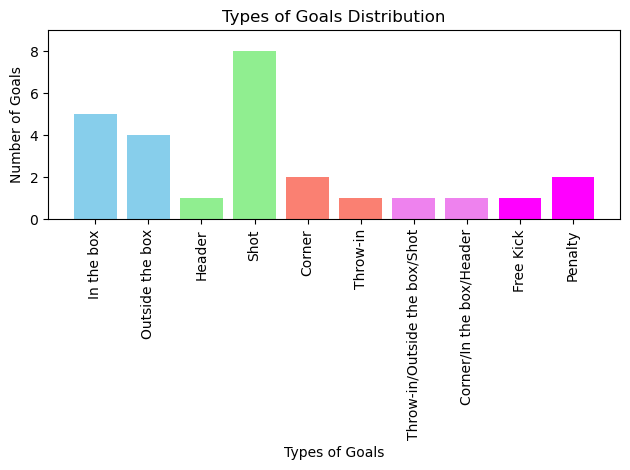

In [121]:
# Define the groups
groups = {
    'In the box': ['touch_in_box'],
    'Outside the box': ['!touch_in_box'], 
    'Header': ['head_shot'],
    #'Header in the box':['touch_in_box','head_shot'],
    'Shot': ['!head_shot'],
    'Corner': ['shot_after_corner'],
    'Throw-in': ['shot_after_throw_in'],
    'Throw-in/Outside the box/Shot': ['shot_after_throw_in', '!touch_in_box'],
    'Corner/In the box/Header': ['touch_in_box','head_shot','shot_after_corner'],
    'Free Kick': ['free_kick_shot'],
    'Penalty': ['penalty_goal']
    
}

# Initialize counts for each group
group_counts = {group: 0 for group in groups}

# Count occurrences of each group
for _, row in df_opp_scorers.iterrows():
    for group, group_objects in groups.items():
        if all(obj in row['type.secondary'] for obj in group_objects if '!' not in obj):
            if all(obj not in row['type.secondary'] for obj in (obj[1:] for obj in group_objects if '!' in obj)):
                group_counts[group] += 1

# Print the counts for each group
print("Counts for each group:")
print(group_counts) 

#Plotting

# Convert the group_counts dictionary to lists for plotting
group_names = list(group_counts.keys())
counts = list(group_counts.values())

# Define colors for pairwise grouping
colors = ['skyblue', 'lightgreen', 'salmon', 'violet', 'magenta']

# Plot the bar chart with pairwise colors
for i in range(len(group_names)):
    color_index = (i // 2) % len(colors)  # Alternate between four colors
    plt.bar(group_names[i], counts[i], color=colors[color_index])

# Add labels and title
plt.xlabel('Types of Goals')
plt.ylabel('Number of Goals')
plt.title('Types of Goals Distribution')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Specify the positions of the ticks on the y-axis
plt.locator_params(axis='y', integer=True)
plt.ylim(0, int(max(counts)) + 1)

# Show the plot
plt.tight_layout()
plt.show()

#### Plotting Shots


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
0    5414104  23.03.2023        H  England           1           2 



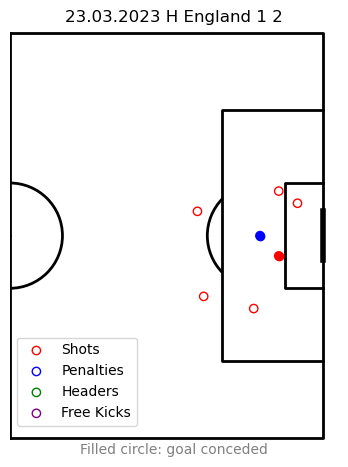


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
1    5414130  26.03.2023        A    Malta           0           2 



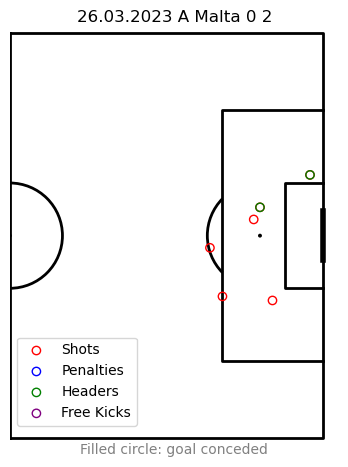


    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
2    5414214  09.09.2023        A  North Macedonia           1           1 



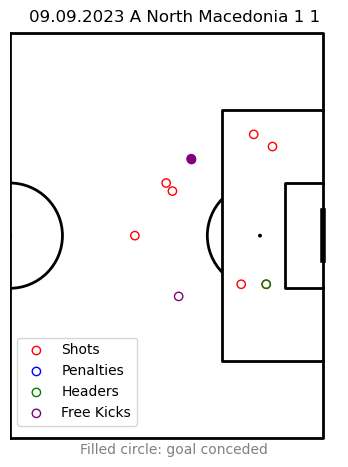


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
3    5414234  12.09.2023        H  Ukraine           2           1 



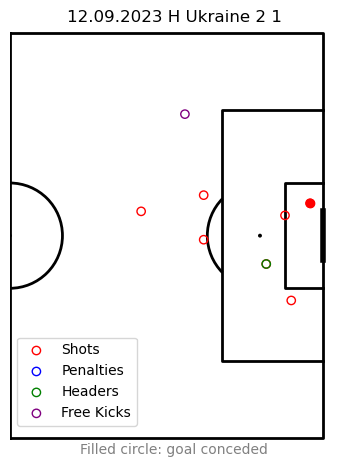


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
4    5414261  14.10.2023        H    Malta           4           0 



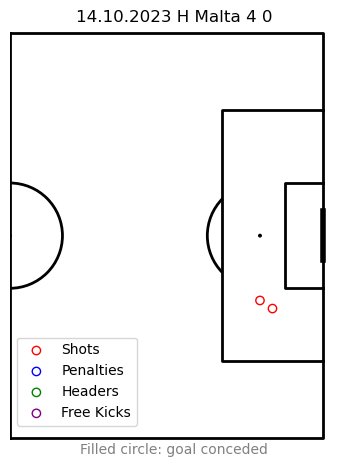


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
5    5414280  17.10.2023        A  England           3           1 



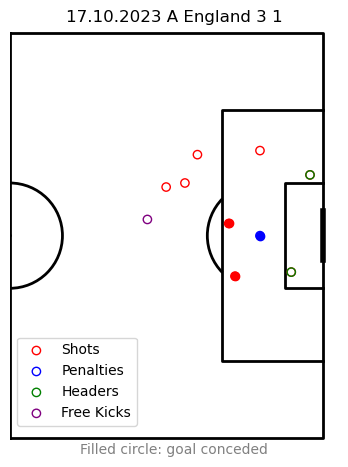


    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
6    5414299  17.11.2023        H  North Macedonia           5           2 



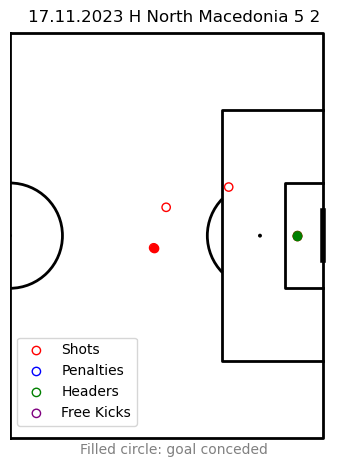


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
7    5414320  20.11.2023        A  Ukraine           0           0 



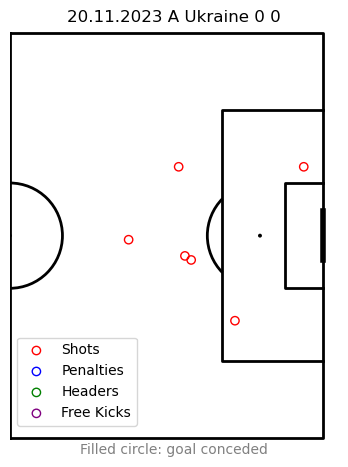

In [122]:
for gameid in game_id:
    game_info = results_short.loc[results_short["wyscoutid"] == gameid]
    print("\n", game_info, "\n")
    
    # Keep only the rows for the specific gameid
    df_game = df_not_Italy[df_not_Italy['matchId'] == gameid]    
    
    # Pure shots and goals from shots
    df_shots = df_game[(df_game['type.primary'] == 'shot') & (~df_game['type.secondary'].isin(['head_shot']))]
    df_goal_shots = df_shots[df_shots['shot.isGoal'] == True]
    
    # Penalties and goals from penalties
    df_pens = df_game[df_game['type.primary'] == 'penalty']
    # print(df_pens)
    df_goal_pens = df_pens[df_pens['shot.isGoal'] == True]
    
    # Shots-header and goals from header
    df_header = df_game[(df_game['type.primary'] == 'shot') & (df_game['type.secondary'].apply(lambda x: 'head_shot' in x))]
    df_goal_header = df_header[df_header['shot.isGoal'] == True]
    
    # Free Kicks
    df_freekick = df_game[(df_game['type.primary'] == 'free_kick') & (df_game['type.secondary'].apply(lambda x: 'free_kick_shot' in x))]
    df_goal_freekick = df_freekick[df_freekick['shot.isGoal'] == True]
    
    # Define the pitch dimensions
    pitch_length = 105  # in meters

    # Create a pitch
    pitch = Pitch(half=True, pitch_length=pitch_length, line_color='black', pitch_type='wyscout', pad_left=-0.05)
    fig, ax = pitch.draw()

    # Plot shots in the right half
    pitch.scatter(df_shots[df_shots['location.x'] > pitch_length / 2]['location.x'], df_shots[df_shots['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='red', label='Shots')

    # Plot penalties in the right half
    pitch.scatter(df_pens[df_pens['location.x'] > pitch_length / 2]['location.x'], df_pens[df_pens['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='blue', label='Penalties')

    # Plot shots from headers in the right half
    pitch.scatter(df_header[df_header['location.x'] > pitch_length / 2]['location.x'], df_header[df_header['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='green', label='Headers')

    # Plot free kick in the right half
    pitch.scatter(df_freekick[df_freekick['location.x'] > pitch_length / 2]['location.x'], df_freekick[df_freekick['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='none', edgecolor='purple', label='Free Kicks')

    # Plot goals from shots in the right half with fillings
    pitch.scatter(df_goal_shots[df_goal_shots['location.x'] > pitch_length / 2]['location.x'], df_goal_shots[df_goal_shots['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='red')

    # Plot goals from penalties in the right half with fillings
    pitch.scatter(df_goal_pens[df_goal_pens['location.x'] > pitch_length / 2]['location.x'], df_goal_pens[df_goal_pens['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='blue')

    # Plot goals from headers in the right half with fillings
    pitch.scatter(df_goal_header[df_goal_header['location.x'] > pitch_length / 2]['location.x'], df_goal_header[df_goal_header['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='green')
    
    # Plot goals from freekick in the right half with fillings
    pitch.scatter(df_goal_freekick[df_goal_freekick['location.x'] > pitch_length / 2]['location.x'], df_goal_freekick[df_goal_freekick['location.x'] > pitch_length / 2]['location.y'], ax=ax, color='purple')

    game_info = results_short.loc[results_short["wyscoutid"] == gameid].drop(columns=['wyscoutid']).reset_index(drop=True)
    game_info = game_info.to_string(index=False, header=None)

    # Show the plot
    plt.legend(bbox_to_anchor=(0, 0.05), loc='lower left')
    plt.title(f'{game_info}', y = 0.97)
    plt.text(0.5, 0.01, 'Filled circle: goal conceded', ha='center', va='center', fontsize=10, color='gray', transform=ax.transAxes)
    plt.show()

### Passing Network

In [123]:
# Function to add the flag picture
def add_flag(ax, flag_path, zoom, position):
    img = plt.imread(flag_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, position, xycoords='axes fraction', frameon=False)
    ax.add_artist(ab)
    
# Function to work on the passing data
def preprocess_team_pass_data(df_events, team_name):
    df_passes = df_events[df_events['type.primary'] == 'pass']
    df_accurate_passes = df_passes[df_passes['pass.accurate'] == True]
    ap_team = df_accurate_passes[df_accurate_passes['team.name'] == team_name]
    filtered_passes = ap_team[['player.name', 'pass.recipient.name', 'location.x', 'location.y']].copy()
    average_positions = ap_team.groupby('player.name').agg({'location.x': 'mean', 'location.y': 'mean'}).reset_index()
    return filtered_passes, average_positions

def create_weighted_graph(df):
    G = nx.DiGraph()
    unique_players = set(df['player.name'])
    unique_recipients = set(df['pass.recipient.name'])

    for index, row in df.iterrows():
        player = row['player.name']
        recipient = row['pass.recipient.name']

        if player is None or recipient is None:
            continue

        if player not in unique_recipients or recipient not in unique_players:
            continue

        if G.has_edge(player, recipient):
            G[player][recipient]['weight'] += 1
        else:
            G.add_edge(player, recipient, weight=1)

    return G

def calculate_top_players(G):
    centrality_measures = {
        "Degree Centrality": nx.degree_centrality(G),
        "Betweenness Centrality": nx.betweenness_centrality(G),
        "Closeness Centrality": nx.closeness_centrality(G),
        "Eigenvector Centrality": nx.eigenvector_centrality(G)
    }

    top_players = {}
    # Loop through each centrality measure
    for measure, centrality in centrality_measures.items():
        sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        top_players[measure] = [f"{player}: {centrality_value:.4f}" for player, centrality_value in sorted_centrality[:3]]

    return top_players

# Plot the data
def plot_weighted_graph_on_pitch(G, average_positions):

    # Define the pitch
    pitch = Pitch(pitch_color='#22312b', stripe=True, stripe_color='#22312b', line_color='white', pitch_type='wyscout')
    fig, ax = pitch.draw(figsize=(10, 10))  
    fig.set_facecolor("#22312b")

    max_density = max(data['weight'] for u, v, data in G.edges(data=True))
    sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])

    for u, v, data in sorted_edges:
        density = data['weight'] / max_density
        color = plt.cm.Reds(density)
        linewidth = 3 + 25 * density
        ax.plot([average_positions.loc[average_positions['player.name'] == u, 'location.x'].values[0],
                 average_positions.loc[average_positions['player.name'] == v, 'location.x'].values[0]],
                [average_positions.loc[average_positions['player.name'] == u, 'location.y'].values[0],
                 average_positions.loc[average_positions['player.name'] == v, 'location.y'].values[0]],
                color=color, linewidth=linewidth, alpha=0.7, zorder=2)

    for index, row in average_positions.iterrows():
        player = row['player.name']
        x = row['location.x']
        y = row['location.y']
        density = sum(G[u][v]['weight'] for u, v in G.edges(player)) / max_density
        size = 50 + 600 * density
        color = plt.cm.Reds(density)
        ax.scatter(x, y, s=size, color=color, zorder=5)
        ax.text(x, y, player, ha='center', va='center', color='white', fontsize=12, fontweight='bold', zorder=6)

        #fig.text(s='6-0', x=0.5, y=0.827, fontsize=18, fontweight="bold", ha='center', color='white')
        #fig.text(s='12.09.2023', x=0.05, y=0.95, fontsize=12, color='white')
        #plt.savefig('network_pass.png') 
        #plt.show()
    


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
0    5414104  23.03.2023        H  England           1           2 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


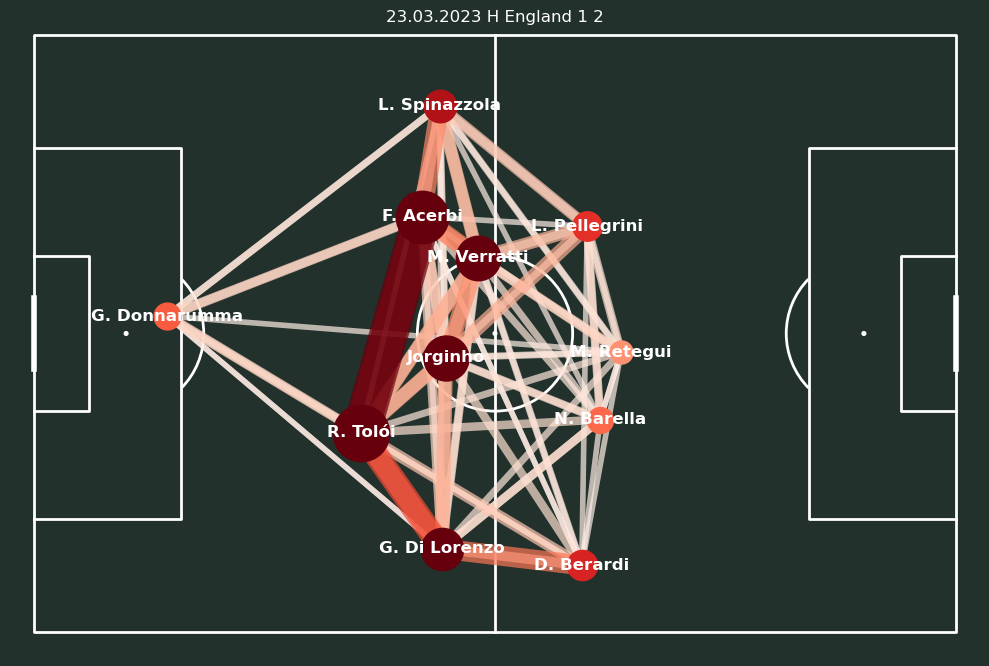


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
1    5414130  26.03.2023        A    Malta           0           2 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


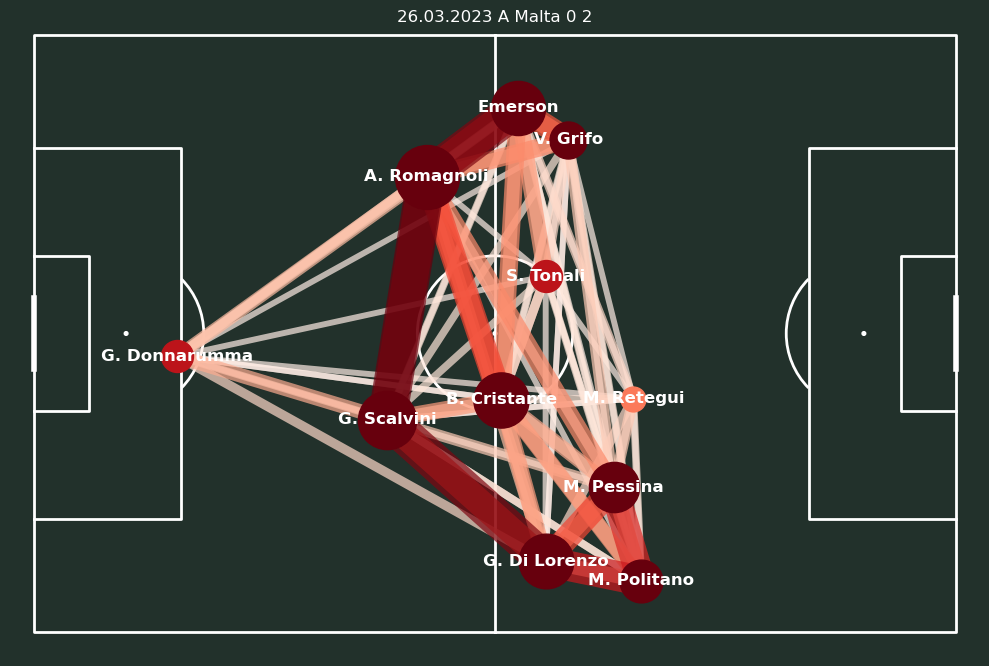


    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
2    5414214  09.09.2023        A  North Macedonia           1           1 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


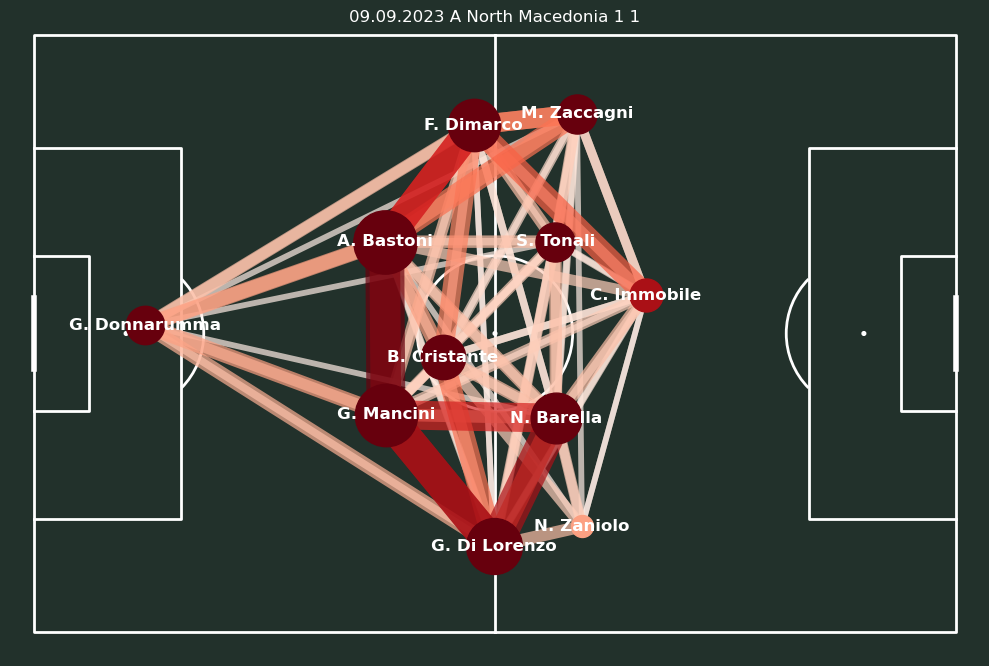


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
3    5414234  12.09.2023        H  Ukraine           2           1 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


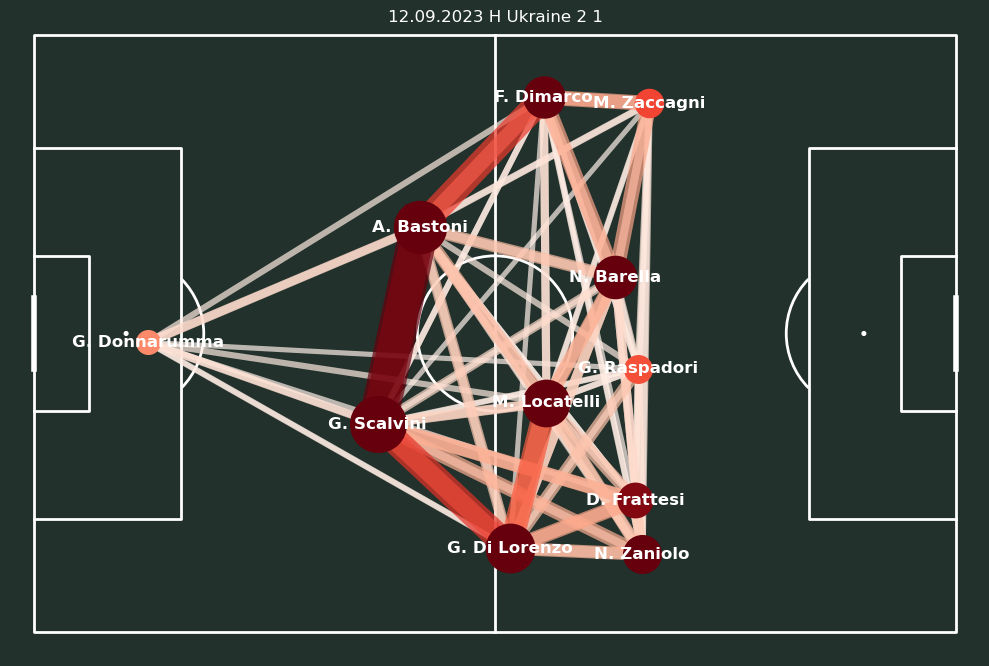


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
4    5414261  14.10.2023        H    Malta           4           0 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


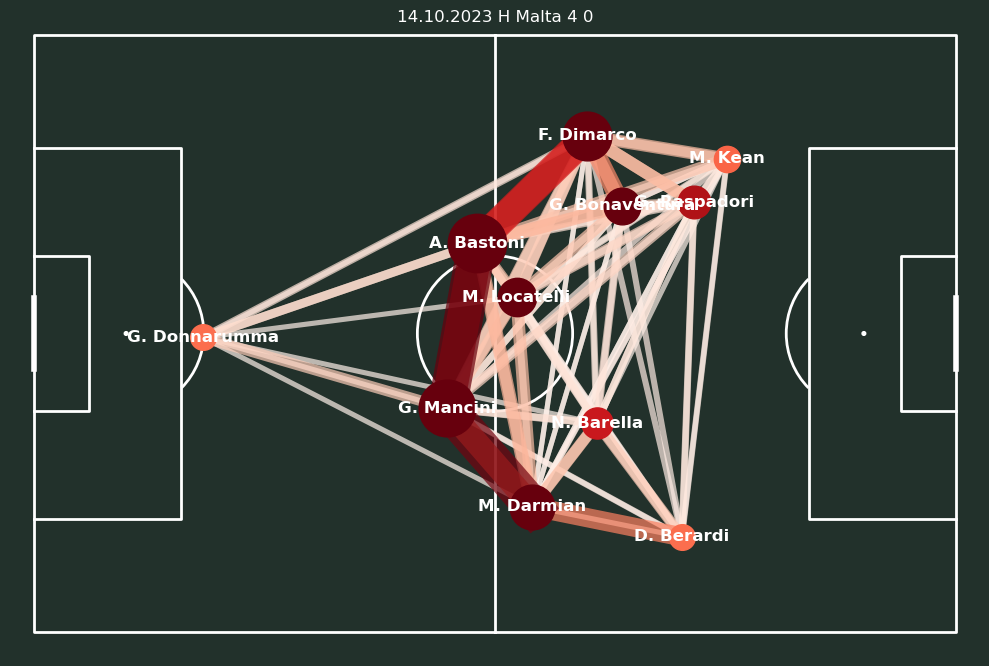


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
5    5414280  17.10.2023        A  England           3           1 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


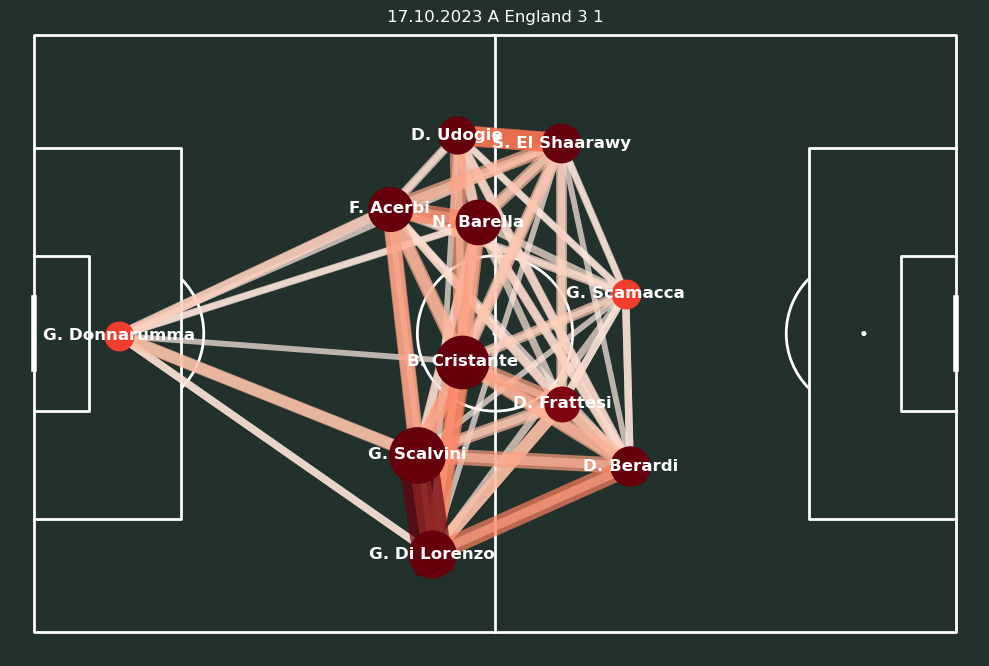


    wyscoutid        Date Location         Opponent  Home Goals  Away Goals
6    5414299  17.11.2023        H  North Macedonia           5           2 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


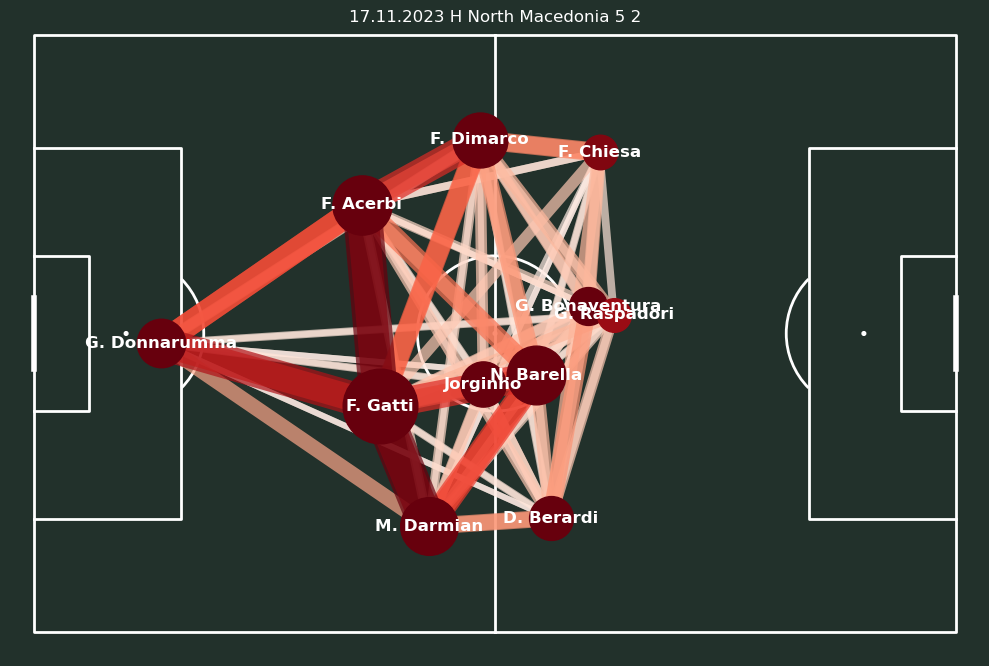


    wyscoutid        Date Location Opponent  Home Goals  Away Goals
7    5414320  20.11.2023        A  Ukraine           0           0 



/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
/var/folders/_x/0shl0zrx325368_h_9vlw8640000gn/T/ipykernel_15460/734191327.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()


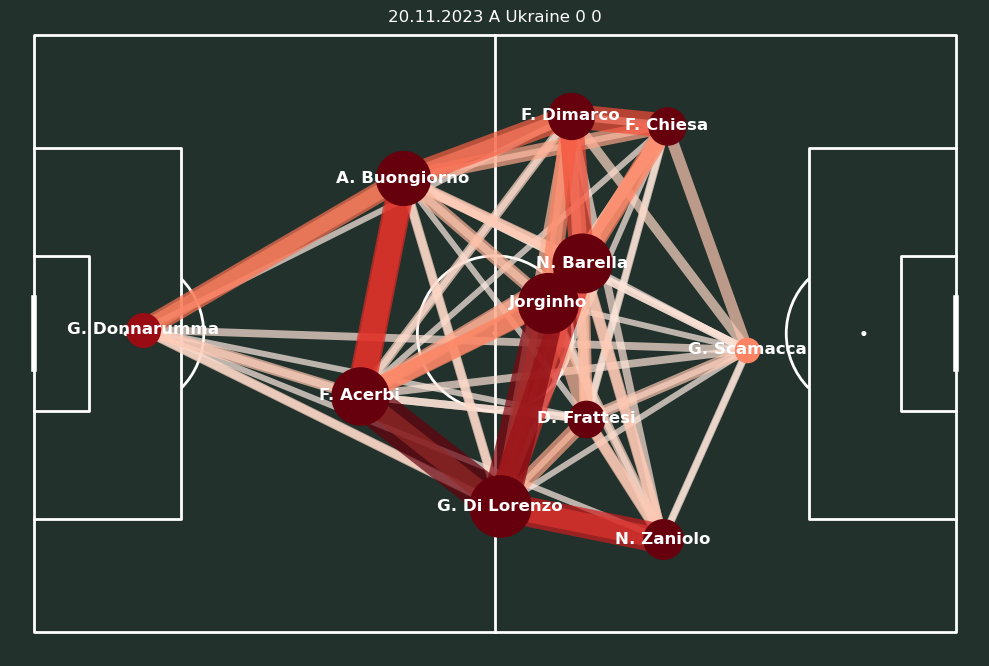

In [124]:
# Iterate over each game ID
for gameid in game_id:
    # Get game information from results_short
    game_info = results_short.loc[results_short["wyscoutid"] == gameid]
    print("\n", game_info, "\n")

    # Get game-specific data from df_Italy
    df_game = df_Italy[df_Italy['matchId'] == gameid]

    # Construct the file path using the game ID
    file_path = f'{gameid}.json'
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        # Normalize the JSON data
        df = pd.json_normalize(data, record_path=['events'])
        df = df[df['team.name'] == 'Italy']

        # Aggregate minutes played by players
        home_player_df = df[df['team.name'] == 'Italy'].groupby('player.name').agg({'minute': [min, max]}).reset_index()
        home_player_df = pd.concat([home_player_df['player.name'], home_player_df['minute']], axis=1)
        home_player_df['minutes_played'] = home_player_df['max'] - home_player_df['min']
        home_player_df = home_player_df.sort_values('minutes_played', ascending=False)

        # Get the top 11 players by minutes played
        home_player_name = home_player_df['player.name'][:11].tolist()
        df = df[df['player.name'].isin(home_player_name)]
        df = df[df['pass.recipient.name'].isin(home_player_name)]

        # Process team pass data and create graph
        filtered_passes_g, average_positions_g = preprocess_team_pass_data(df, 'Italy')
        G = create_weighted_graph(filtered_passes_g)
        calculate_top_players(G)

        # Plot
        plot_weighted_graph_on_pitch(G, average_positions_g)
        
        game_info = results_short.loc[results_short["wyscoutid"] == gameid].drop(columns=['wyscoutid']).reset_index(drop=True)
        game_info = game_info.to_string(index=False, header=None)
        plt.title(f'{game_info}', y = 0.97, color = 'white')
        plt.savefig(f'pass_network_{gameid}.png') 
        plt.show()

    except FileNotFoundError:
        print(f"File for game ID {gameid} not found.")